In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".2"

import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit, lax, grad, value_and_grad

from neuron import h
_ = h.load_file("stdlib.hoc")

from neurax.integrate import solve, solve_and_grad
from neurax.cell import Cell
from neurax.stimulus import Stimulus, step_current
from neurax.recording import Recording
from neurax.connection import Connection

--No graphics will be displayed.


In [3]:
device_str = "gpu"
jax.config.update('jax_platform_name', device_str)

cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

device = cpus[0] if device_str == "cpu" else gpus[0]

# Solve

### Define model

In [40]:
num_cells = 32
nseg_per_branch = 16
num_branches = 15
ncomp = num_branches * nseg_per_branch
parents = jnp.asarray([-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])

assert len(parents) == num_branches
g_na = jnp.asarray([[0.12] * ncomp] * num_cells)
g_kd = jnp.asarray([[0.036] * ncomp] * num_cells)
g_leak = jnp.asarray([[0.0003] * ncomp] * num_cells)
params = jnp.stack([g_na, g_kd, g_leak])

init_v = jnp.asarray([[-62.0] *num_branches*nseg_per_branch] * num_cells)
init_m = jnp.asarray([[0.074901] *num_branches*nseg_per_branch] * num_cells)
init_h = jnp.asarray([[0.4889] *num_branches*nseg_per_branch] * num_cells)
init_n = jnp.asarray([[0.3644787] *num_branches*nseg_per_branch] * num_cells)
u = jnp.stack([init_v, init_m, init_h, init_n])

length = 100.0  # um (length of a single branch)
radius = 10.0  # um
r_a = 10_000  # ohm cm 
i_delay = 5.0  # ms
i_amp = 1.0  # nA
i_dur = 2.0  # ms
dt = 0.025  # ms
t_max = 20.0  # ms

### Set up model

In [41]:
time_vec = jnp.arange(0, t_max+dt, dt)

In [42]:
cells = [Cell(num_branches, parents, nseg_per_branch, length, radius, r_a)] * num_cells
stims = [
    Stimulus(cell_ind=0, branch_ind=0, loc=0.0, current=step_current(i_delay, i_dur, i_amp, time_vec)),
    Stimulus(cell_ind=1, branch_ind=0, loc=0.0, current=step_current(i_delay, i_dur, i_amp, time_vec)),
]
recs = [
    Recording(0, 0, 0.0),
    Recording(0, 6, 1.0),
    Recording(1, 0, 0.0),
    Recording(1, 6, 1.0),
    Recording(3, 0, 0.0),
    Recording(3, 6, 1.0),
    Recording(4, 0, 0.0),
    Recording(4, 6, 1.0),
]
conns = [
    Connection(0, 0, 0.0, 3, 0, 0.0, synaptic_cond=1.0),
    Connection(1, 0, 0.0, 3, 0, 0.3, synaptic_cond=1.0),
]

### Run solver

In [43]:
start_time = time.time()
s = solve(cells, u, params, stims, recs, conns, t_max=t_max, dt=dt, solver="stone")
print("Time: ", time.time() - start_time)

Time:  0.2766544818878174


### Vis

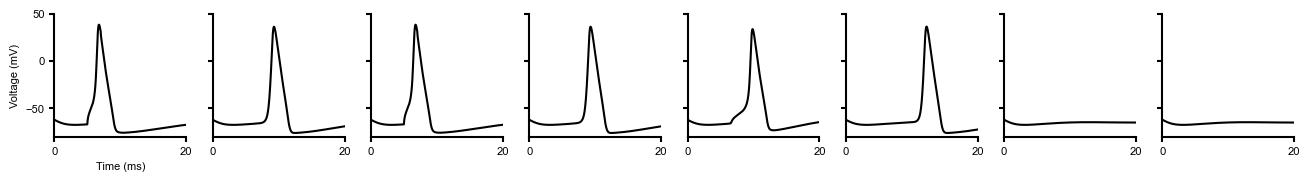

In [44]:
num_recs = 8
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, num_recs, figsize=(num_recs * 2, 1.6))
    ax = np.atleast_1d(ax)
    for i in range(num_recs):
        _ = ax[i].plot(time_vec, s[i], c="k")

    _ = ax[0].set_xlabel("Time (ms)")
    _ = ax[0].set_ylabel("Voltage (mV)")
    
    for a in ax[1:]:
        a.set_yticklabels([])
    for a in ax:
        _ = a.set_ylim([-80, 50])
        a.set_xticks([0, t_max])
        a.set_xlim([0, t_max])
    plt.show()

# Gradient

In [52]:
checkpoint_inds = [200, 400, 600]
def sum_ode(diff_params):
    s = solve_and_grad(cells, u, diff_params, stims, recs, conns, t_max=t_max, dt=dt, solver="stone", checkpoint_inds=checkpoint_inds)
    return jnp.mean(s)

In [53]:
jitted_sum_ode = jit(sum_ode)

In [55]:
start_time = time.time()
result = jitted_sum_ode(params)
print("Time:  ", time.time() - start_time)

Time:   0.22594618797302246


In [56]:
jitted_grad = jit(value_and_grad(sum_ode))

In [58]:
start_time = time.time()
result = jitted_grad(params)
print("Time:  ", time.time() - start_time)
print("Solve", result[0])
print("Grad", result[1][:, 0, ::100])

Time:   2.9018635749816895
Solve -61.26784
Grad [[-1.8830334e-03  6.6960134e-02 -4.4424207e-05]
 [-9.2289299e-02 -4.3984312e-01 -3.4559614e-03]
 [ 1.1711740e+01  2.0708889e+01  3.9166570e-01]]
